# Model Calibration with Epydemix (R Version)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ngozzi/tech-transfer-epdemix/blob/main/sessions/session-3/r-colab/02_calibration_tutorial.ipynb)

This tutorial covers calibrating epidemic models to observed data using Approximate Bayesian Computation (ABC) methods—all using R via the `reticulate` package.

**What you'll learn:**
- Set up calibration with prior distributions and distance functions
- Compare three ABC calibration strategies: ABC-SMC, ABC Rejection, and Top X%
- Visualize posterior distributions and calibration fits
- Run projections from calibrated models

In [2]:
!pip install epydemix
%load_ext rpy2.ipython

ERROR: Exception:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 106, in _run_wrapper
    status = _inner_run()
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 97, in _inner_run
    return self.run(options, args)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/commands/install.py", line 484, in run
    installed_versions[distribution.canonical_name] = distribution.version
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/metadata/pkg_resources.py", line 192, in version
    return parse_version(self._dist.version)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_vendor/packaging/version.py", line 56, in parse
    return Version(version)
  File "/opt/anaconda3/lib/python3.8/site-packages

In [3]:
%%R
# Install and load reticulate
if (!require("reticulate", quietly = TRUE)) {
  install.packages("reticulate")
}
library(reticulate)
use_python("/usr/bin/python3", required = TRUE)
py_config()


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    python:         /opt/anaconda3/bin/python
libpython:      /opt/anaconda3/bin/python3.8
pythonhome:     /opt/anaconda3:/opt/anaconda3
version:        3.8.8 (default, Apr 13 2021, 12:59:45)  [Clang 10.0.0 ]
numpy:          /opt/anaconda3/lib/python3.8/site-packages/numpy
numpy_version:  1.24.4

NOTE: Python version was forced by the current process


In addition: Warning message:
package ‘reticulate’ was built under R version 4.3.3 


---
## 1. Loading and Exploring the Data

We'll calibrate an SIR model to synthetic incidence data (new infections per day) from North Carolina. The data was generated from an SIR model with known parameters, plus observation noise.

In [24]:
%%R
library(readr)
library(ggplot2)
library(dplyr)

# Load the CSV directly from GitHub
data <- read_csv(
    "https://raw.githubusercontent.com/ngozzi/tech-transfer-epydemix/refs/heads/main/sessions/session-3/data/incidence_data.csv", 
    show_col_types = FALSE
)

# Ensure "date" is a Date object
data <- data %>% mutate(date = as.Date(date))

# Split into calibration and projection periods
n_total <- nrow(data)
n_calibration <- n_total - 40
data_calibration <- data[1:n_calibration, ]
data_projection <- data[(n_calibration + 1):n_total, ]

cat(sprintf("Calibration period: %s to %s (%d days)\n",
            data_calibration$date[1],
            data_calibration$date[nrow(data_calibration)],
            nrow(data_calibration)))
cat(sprintf("Projection period: %s to %s (%d days)\n",
            data_projection$date[1],
            data_projection$date[nrow(data_projection)],
            nrow(data_projection)))

Calibration period: 2025-01-01 to 2025-04-21 (111 days)
Projection period: 2025-04-22 to 2025-05-31 (40 days)


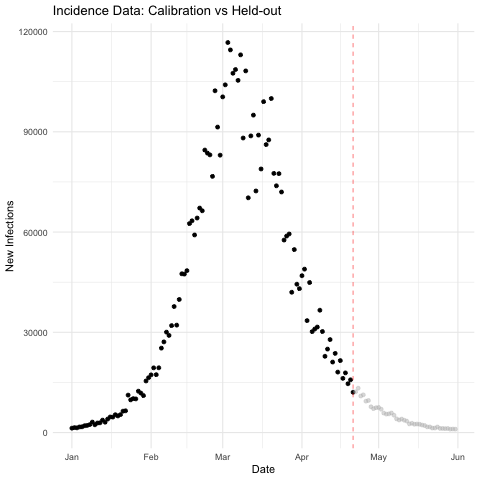

In [25]:
%%R
# Plot the data
ggplot() +
  geom_point(data = data_calibration, aes(x = date, y = data), color = "black") +
  geom_point(data = data_projection, aes(x = date, y = data), color = "gray", alpha = 0.5) +
  geom_vline(xintercept = as.numeric(data_calibration$date[nrow(data_calibration)]),
             color = "red", linetype = "dashed", alpha = 0.5) +
  labs(x = "Date", y = "New Infections", title = "Incidence Data: Calibration vs Held-out") +
  theme_minimal()

---
## 2. Setting Up the Model

We'll use a predefined SIR model with Indonesia's population data.

In [6]:
%%R
# Import epydemix
epydemix <- import("epydemix")
load_predefined_model <- epydemix$load_predefined_model

# Load predefined SIR model
model <- load_predefined_model("SIR")
model$import_epydemix_population(population_name = "United_States_North_Carolina")

model

EpiModel(name='EpiModel')
Compartments: 3
  Susceptible, Infected, Recovered
Transitions: 2
  Transitions between compartments:
    Susceptible -> Infected, params: ('transmission_rate', 'Infected') (kind: mediated)
    Infected -> Recovered, params: recovery_rate (kind: spontaneous)
Parameters: 2
  Model parameters:
    transmission_rate: 0.3
    recovery_rate: 0.1
Population: United_States_North_Carolina
  Population size: 10835491 individuals
  Demographic groups: 5
    0-4, 5-19, 20-49, 50-64, 65+



In [7]:
%%R
# Import utils
utils_module <- import("epydemix.utils")
compute_simulation_dates <- utils_module$compute_simulation_dates

# Get population size
Nk_r <- py_to_r(model$population$Nk)

# Initial conditions: 0.05% of population infected
infected <- as.integer(Nk_r * 0.05 / 100)
susceptible <- as.integer(Nk_r - infected)
recovered <- rep(0L, length(Nk_r))

initial_conditions <- reticulate::dict(
  Susceptible = susceptible,
  Infected = infected,
  Recovered = recovered
)

# Simulation dates
start_date_chr <- as.character(data_calibration$date[1])
end_date_calibration_chr <- as.character(data_calibration$date[nrow(data_calibration)])
end_date_projection_chr <- as.character(data_projection$date[nrow(data_projection)])

# Parameters dict for calibration
parameters <- reticulate::dict(
  initial_conditions_dict = initial_conditions,
  epimodel = model,
  start_date = start_date_chr,
  end_date = end_date_calibration_chr
)

# Compute simulation dates
simulation_dates_calibration <- compute_simulation_dates(
  start_date = start_date_chr,
  end_date = end_date_calibration_chr
)

simulation_dates_projection <- compute_simulation_dates(
  start_date = start_date_chr,
  end_date = end_date_projection_chr
)

---
## 3. Defining Priors and the Calibration Wrapper

### Prior Distributions

Prior distributions encode our beliefs about parameter values before seeing the data. We use `scipy.stats` distributions:

In [8]:
%%R
# Import scipy.stats
scipy_stats <- import("scipy.stats")

# Uniform priors for transmission and recovery rates
priors <- reticulate::dict(
  transmission_rate = scipy_stats$uniform(loc = 0.010, scale = 0.020),  # U(0.01, 0.03)
  recovery_rate = scipy_stats$uniform(loc = 0.15, scale = 0.1)          # U(0.15, 0.25)
)

priors

{'transmission_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen>, 'recovery_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen>}


### Simulation Wrapper Function

The `ABCSampler` requires a function that returns a dictionary with a `'data'` key containing the quantity to compare against observations. This wrapper extracts new infections (S→I transitions) from the simulation output.

**Note:** We define this wrapper in Python since it needs to be callable by the Python calibration engine.

In [9]:
%%R
# Import calibration module
calib <- import("epydemix.calibration")
ABCSampler <- calib$ABCSampler
rmse <- calib$rmse

# Define the wrapper function in Python (required for ABCSampler)
py_run_string("
from epydemix import simulate

def simulate_wrapper(parameters):
    results = simulate(**parameters)
    return {'data': results.transitions['Susceptible_to_Infected_total']}
")

simulate_wrapper <- py$simulate_wrapper

# Observed data as R numeric vector
observed_data <- data_calibration$data

# Initialize the ABC sampler
abc_sampler <- ABCSampler(
  simulation_function = simulate_wrapper,
  priors = priors,
  parameters = parameters,
  observed_data = observed_data,
  distance_function = rmse  # Root Mean Squared Error
)

abc_sampler

---
## 4. Running Calibration

Epydemix supports three calibration strategies:

| Method | Description | When to Use |
|--------|-------------|-------------|
| **ABC-SMC** | Sequential Monte Carlo with adaptive tolerance | Most accurate, recommended for final results |
| **ABC Rejection** | Simple accept/reject with fixed tolerance | Fast exploratory analysis |
| **Top X%** | Keep best fraction of simulations | Fixed runtime, good for prototyping |

Let's run all three and compare.

In [10]:
%%R
# ABC-SMC: 5 generations, 100 particles per generation
results_abc_smc <- abc_sampler$calibrate(
  strategy = "smc",
  num_particles = 100L,
  num_generations = 5L
)

Starting ABC-SMC with 100 particles and 5 generations

Generation 1/5 (epsilon: inf)
	Accepted 100/100 (acceptance rate: 100.00%)
	Elapsed time: 00:00:04

Generation 2/5 (epsilon: 54790.113086)
	Accepted 100/198 (acceptance rate: 50.51%)
	Elapsed time: 00:00:08

Generation 3/5 (epsilon: 35106.777354)
	Accepted 100/258 (acceptance rate: 38.76%)
	Elapsed time: 00:00:11

Generation 4/5 (epsilon: 18307.660465)
	Accepted 100/547 (acceptance rate: 18.28%)
	Elapsed time: 00:00:27

Generation 5/5 (epsilon: 13303.337117)
	Accepted 100/682 (acceptance rate: 14.66%)
	Elapsed time: 00:00:26


In [11]:
%%R
# ABC Rejection: fixed tolerance based on ABC-SMC final epsilon
results_abc_rejection <- abc_sampler$calibrate(
  strategy = "rejection",
  num_particles = 100L,
  epsilon = 17000
)

Starting ABC rejection sampling with 100 particles and epsilon threshold 17000.0
	Simulations: 1000, Accepted: 73, Acceptance rate: 7.30%
	Final: 100 particles accepted from 1417 simulations (7.06% acceptance rate)


In [12]:
%%R
# Top X%: keep best 10% of 1000 simulations
results_top_perc <- abc_sampler$calibrate(
  strategy = "top_fraction",
  Nsim = 1000L,
  top_fraction = 0.1
)

Starting ABC top fraction selection with 1000 simulations and top 10.0% selected


	Progress: 100/1000 simulations completed (10.0%)
	Progress: 200/1000 simulations completed (20.0%)
	Progress: 300/1000 simulations completed (30.0%)
	Progress: 400/1000 simulations completed (40.0%)
	Progress: 500/1000 simulations completed (50.0%)
	Progress: 600/1000 simulations completed (60.0%)
	Progress: 700/1000 simulations completed (70.0%)
	Progress: 800/1000 simulations completed (80.0%)
	Progress: 900/1000 simulations completed (90.0%)
	Progress: 1000/1000 simulations completed (100.0%)
	Selected 100 particles (top 10.0%) with distance threshold 20852.667968


---
## 5. Comparing Calibration Results

### Calibration Fits

Let's visualize how well each method fits the observed data:

<Axes: title={'center': 'ABC-SMC'}>


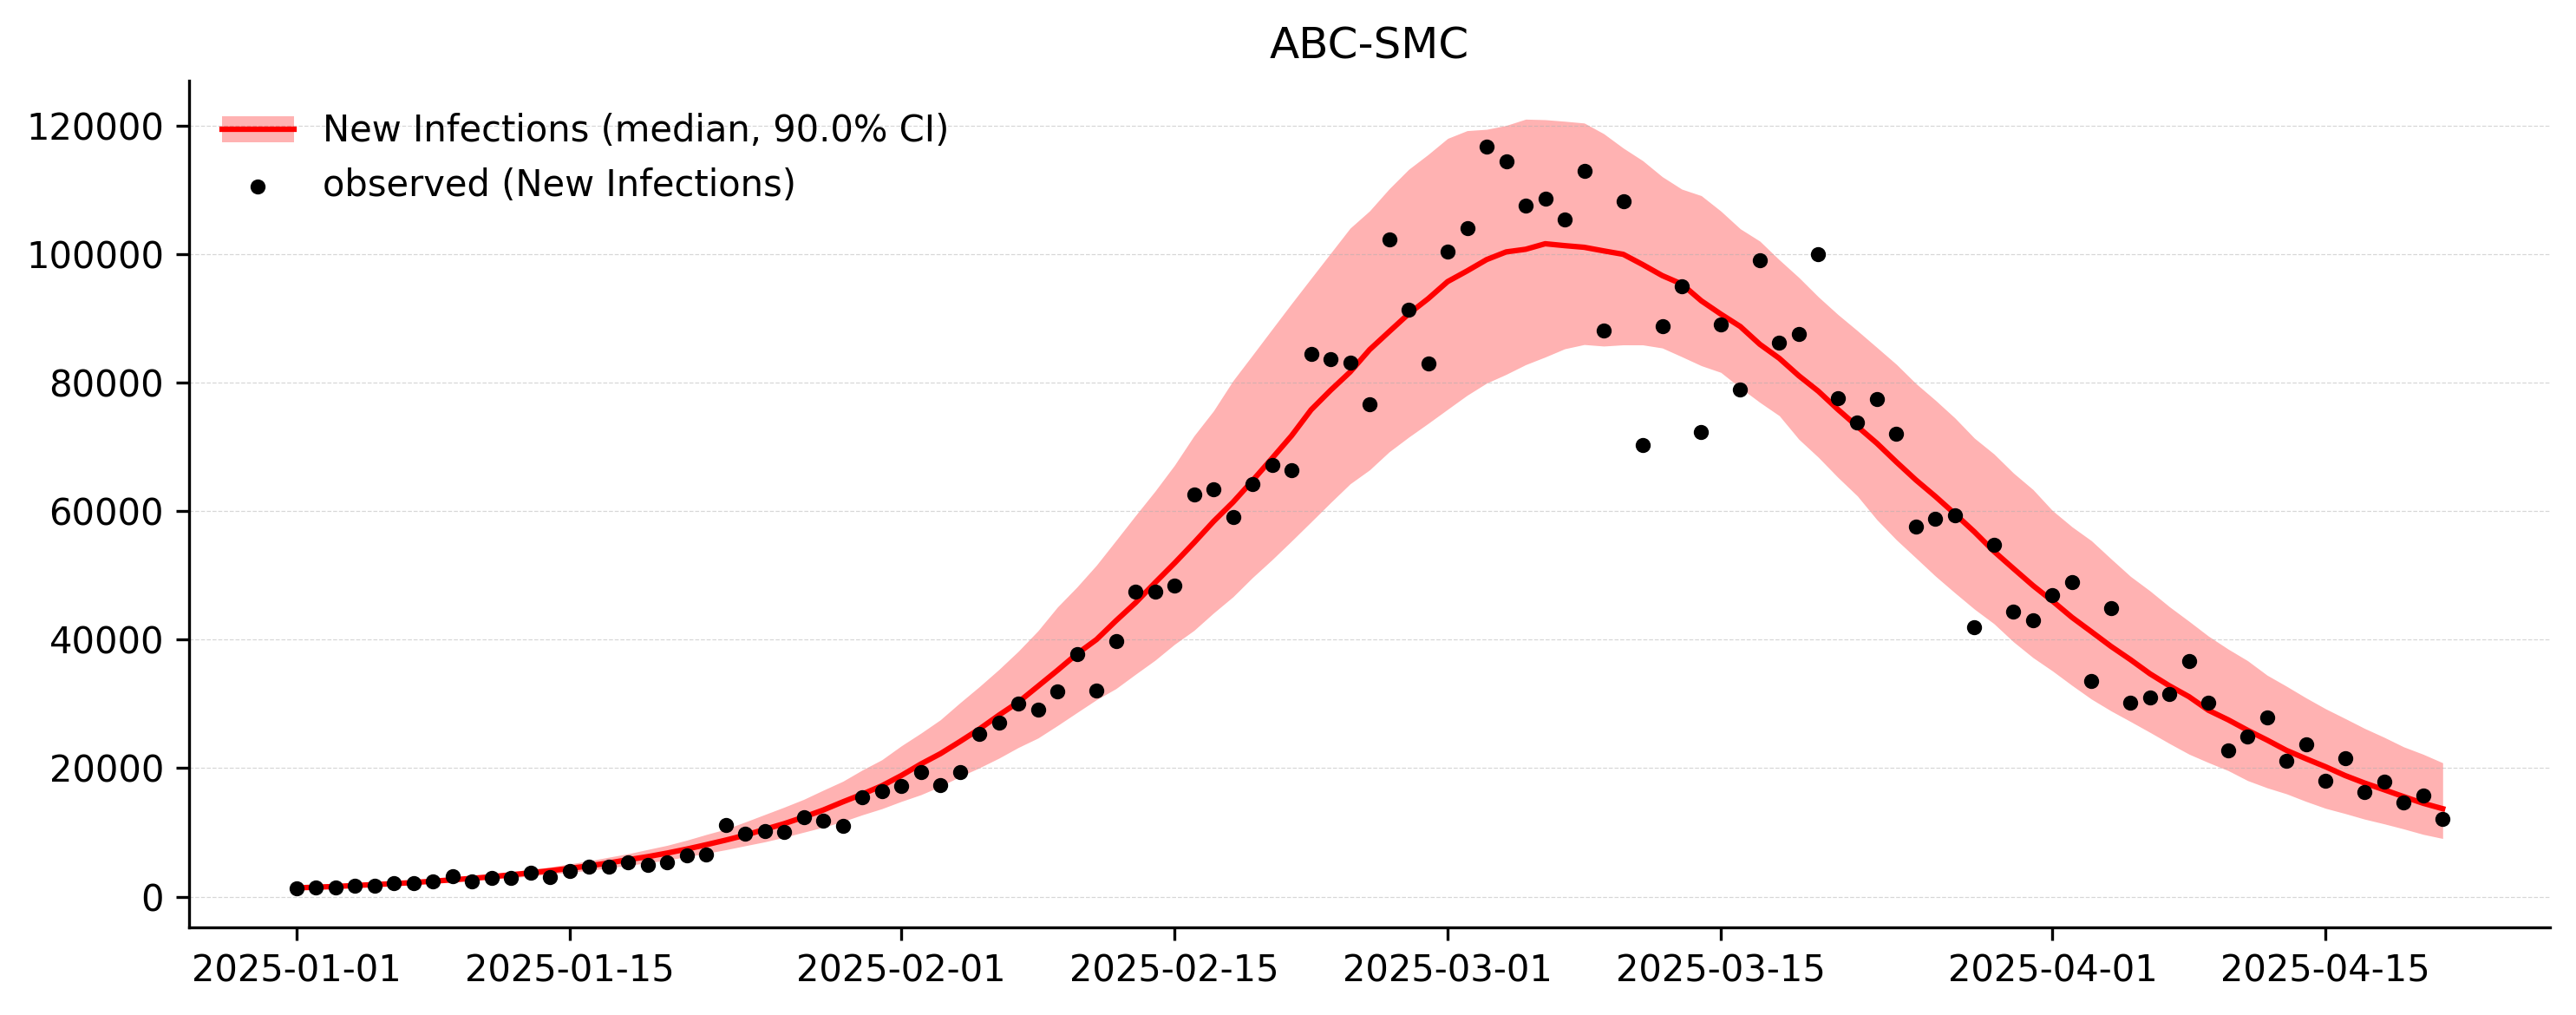

In [13]:
%%R
# Import visualization functions
viz <- import("epydemix.visualization")
plot_quantiles <- viz$plot_quantiles

# Get quantiles for each method
df_quantiles_smc <- results_abc_smc$get_calibration_quantiles(dates = simulation_dates_calibration)
df_quantiles_rejection <- results_abc_rejection$get_calibration_quantiles(dates = simulation_dates_calibration)
df_quantiles_top <- results_top_perc$get_calibration_quantiles(dates = simulation_dates_calibration)

# Plot ABC-SMC
plot_quantiles(
  df_quantiles_smc,
  columns = "data",
  data = data_calibration,
  title = "ABC-SMC",
  colors = "red",
  show_data = TRUE,
  labels = list("New Infections")
)

<Axes: title={'center': 'ABC Rejection'}>


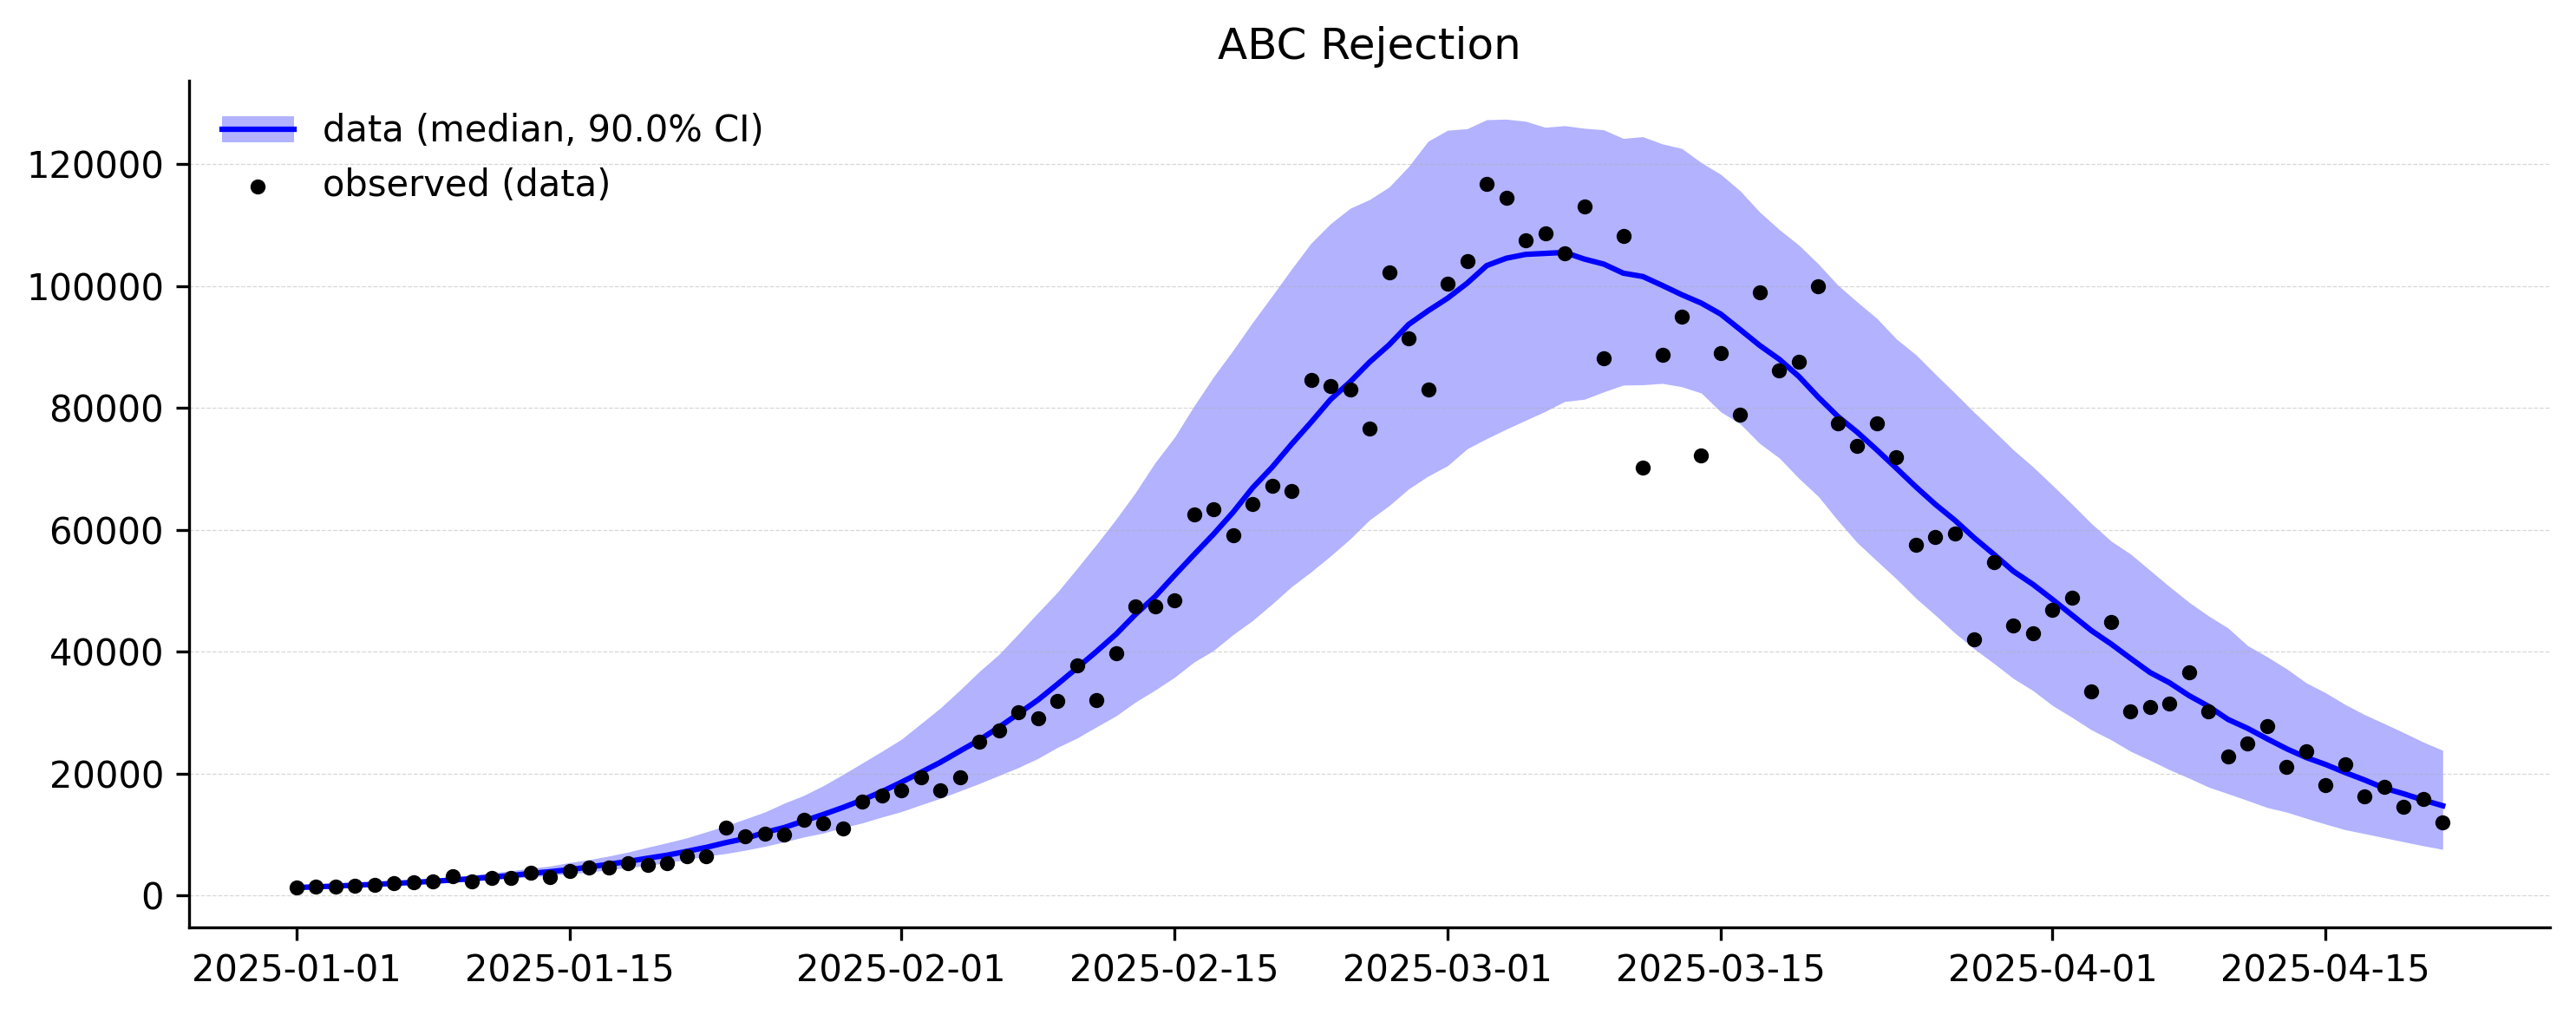

In [14]:
%%R
# Plot ABC Rejection
plot_quantiles(
  df_quantiles_rejection,
  columns = "data",
  data = data_calibration,
  title = "ABC Rejection",
  colors = "blue",
  show_data = TRUE
)

<Axes: title={'center': 'Top 10%'}>


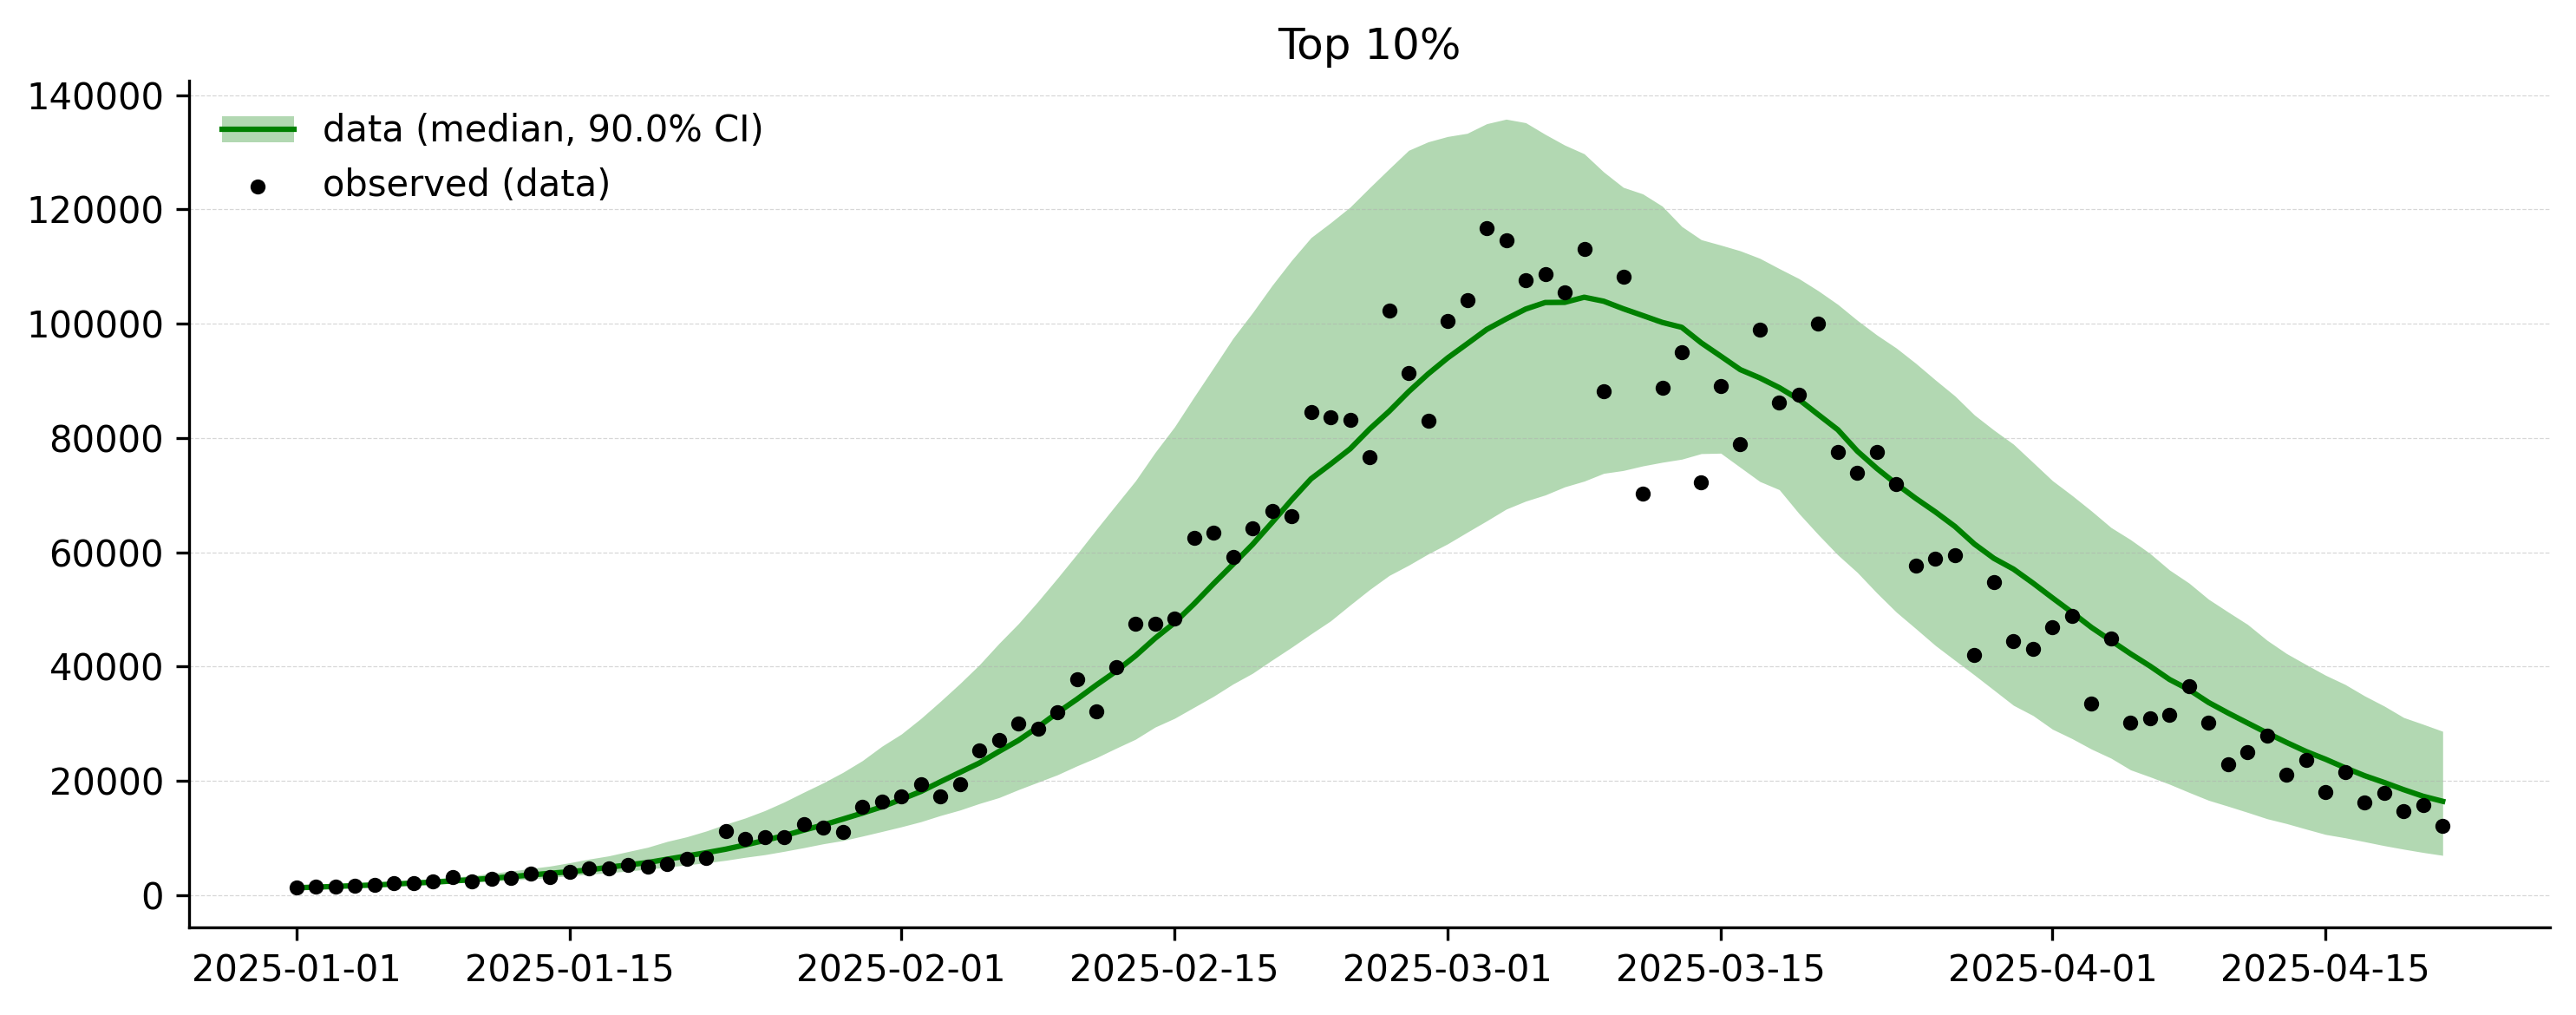

In [15]:
%%R
# Plot Top 10%
plot_quantiles(
  df_quantiles_top,
  columns = "data",
  data = data_calibration,
  title = "Top 10%",
  colors = "green",
  show_data = TRUE
)

### Posterior Distributions

The posterior distribution shows our updated beliefs about parameter values after seeing the data. Let's compare the 2D joint posteriors:

<Axes: title={'center': 'ABC-SMC'}, xlabel='transmission_rate', ylabel='recovery_rate'>


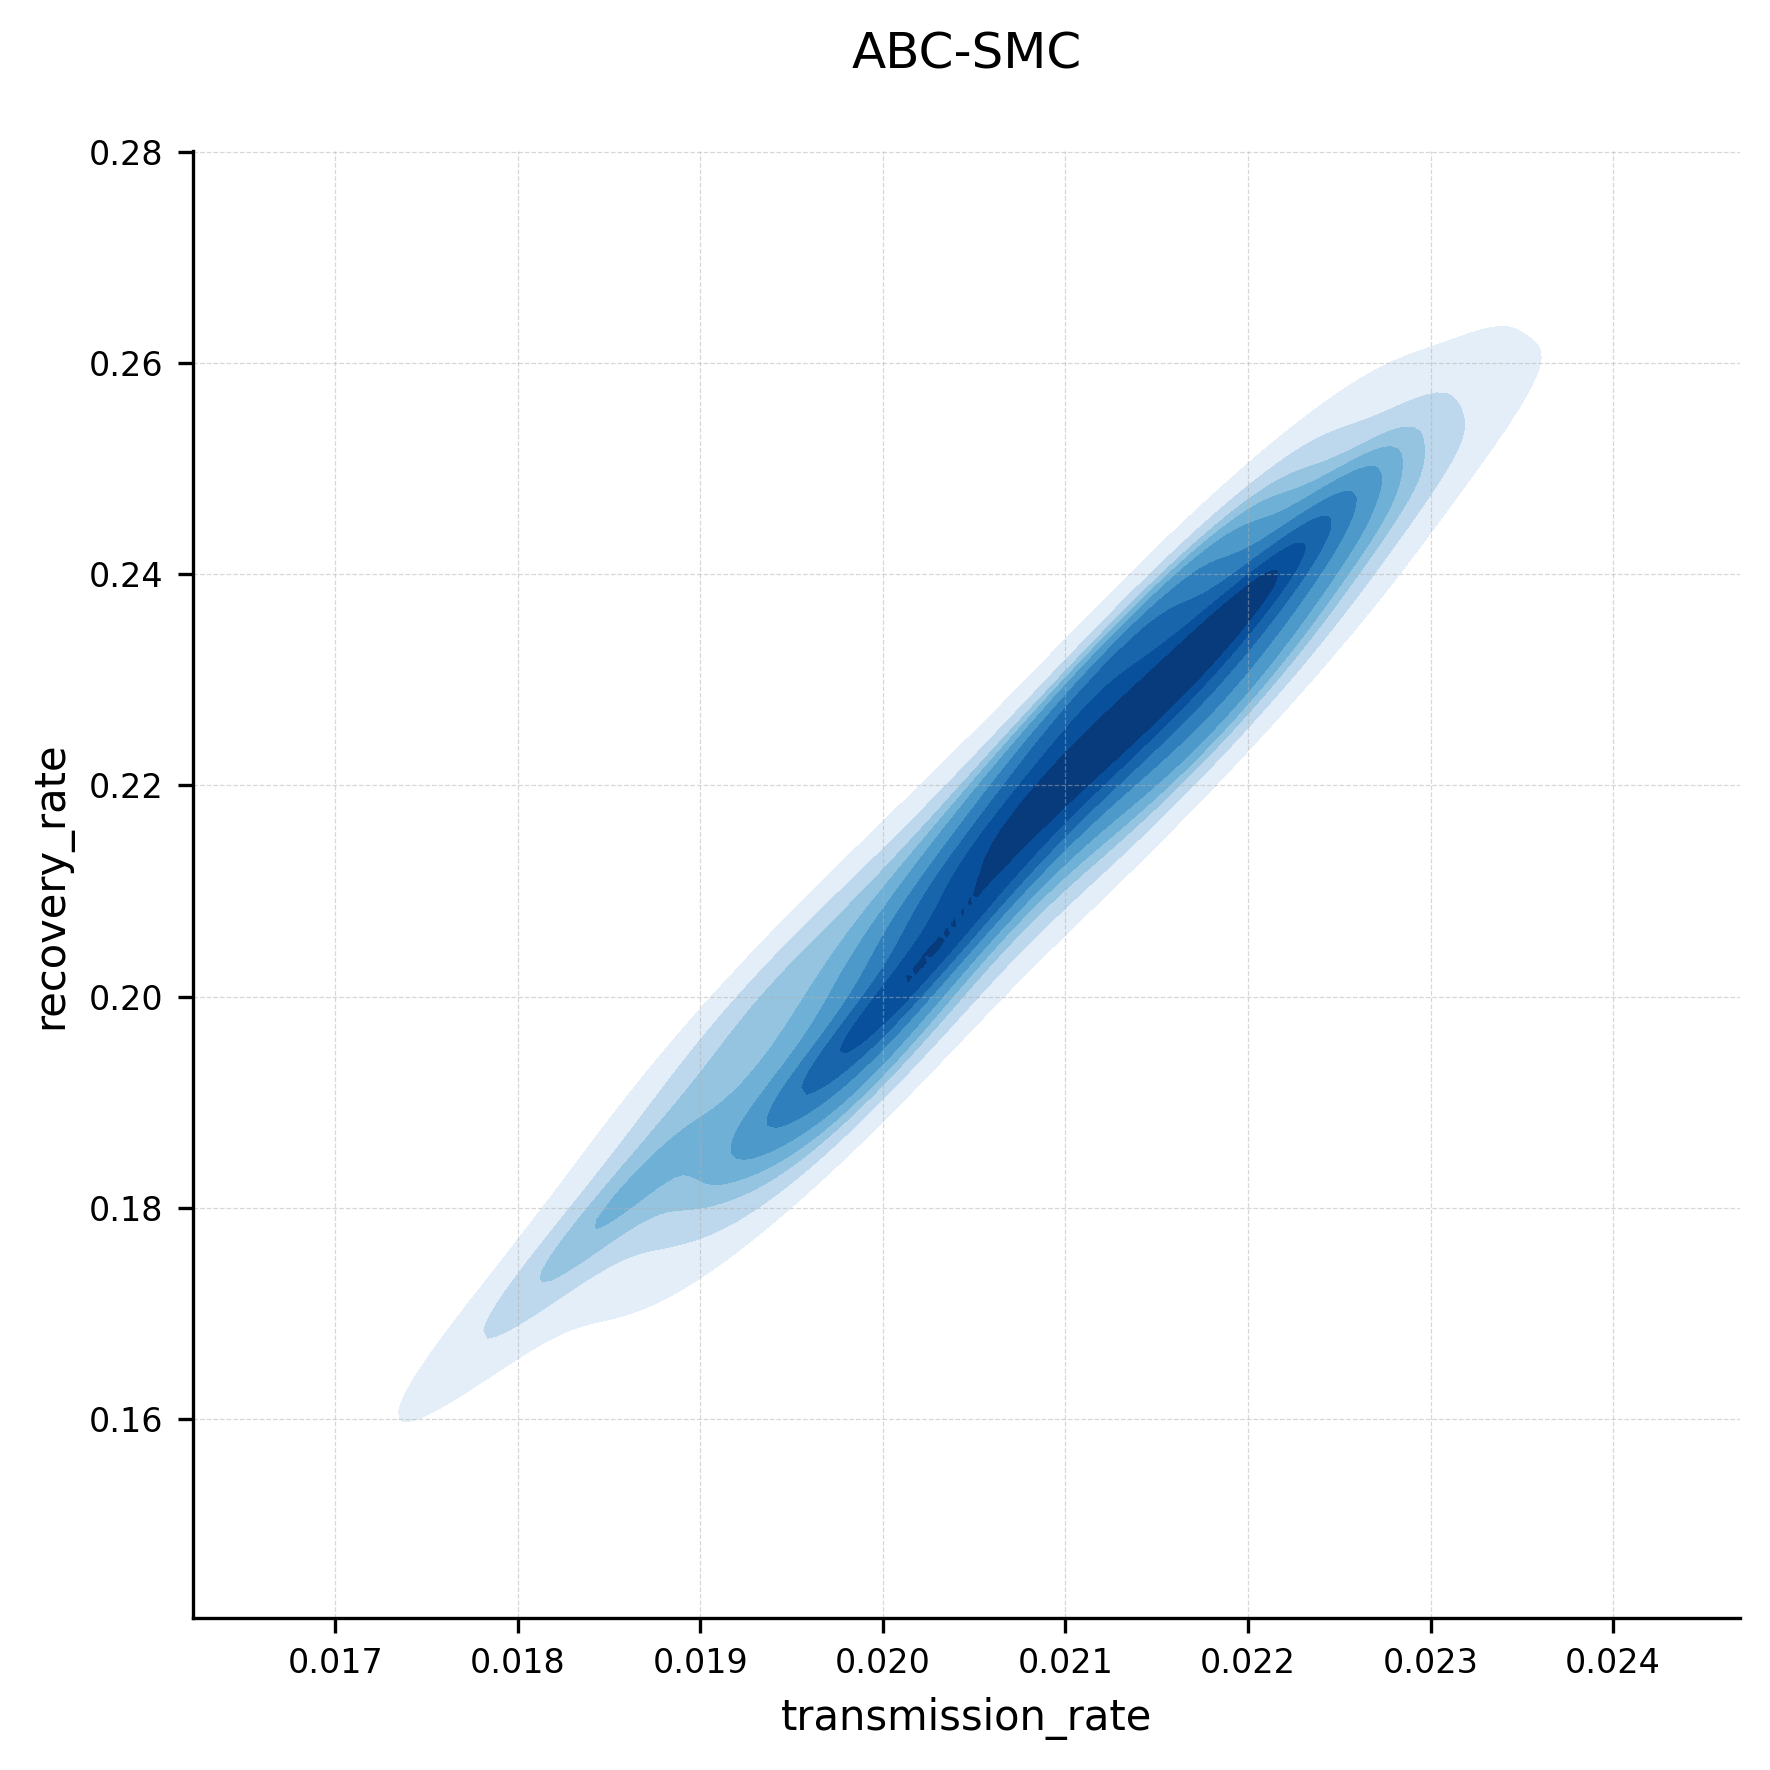

In [16]:
%%R
# Import 2D posterior plotting
plot_posterior_distribution_2d <- viz$plot_posterior_distribution_2d

# ABC-SMC posterior
plot_posterior_distribution_2d(
  results_abc_smc$get_posterior_distribution(),
  "transmission_rate",
  "recovery_rate",
  kind = "kde",
  title = "ABC-SMC",
  prior_range = FALSE
)

<Axes: title={'center': 'ABC Rejection'}, xlabel='transmission_rate', ylabel='recovery_rate'>


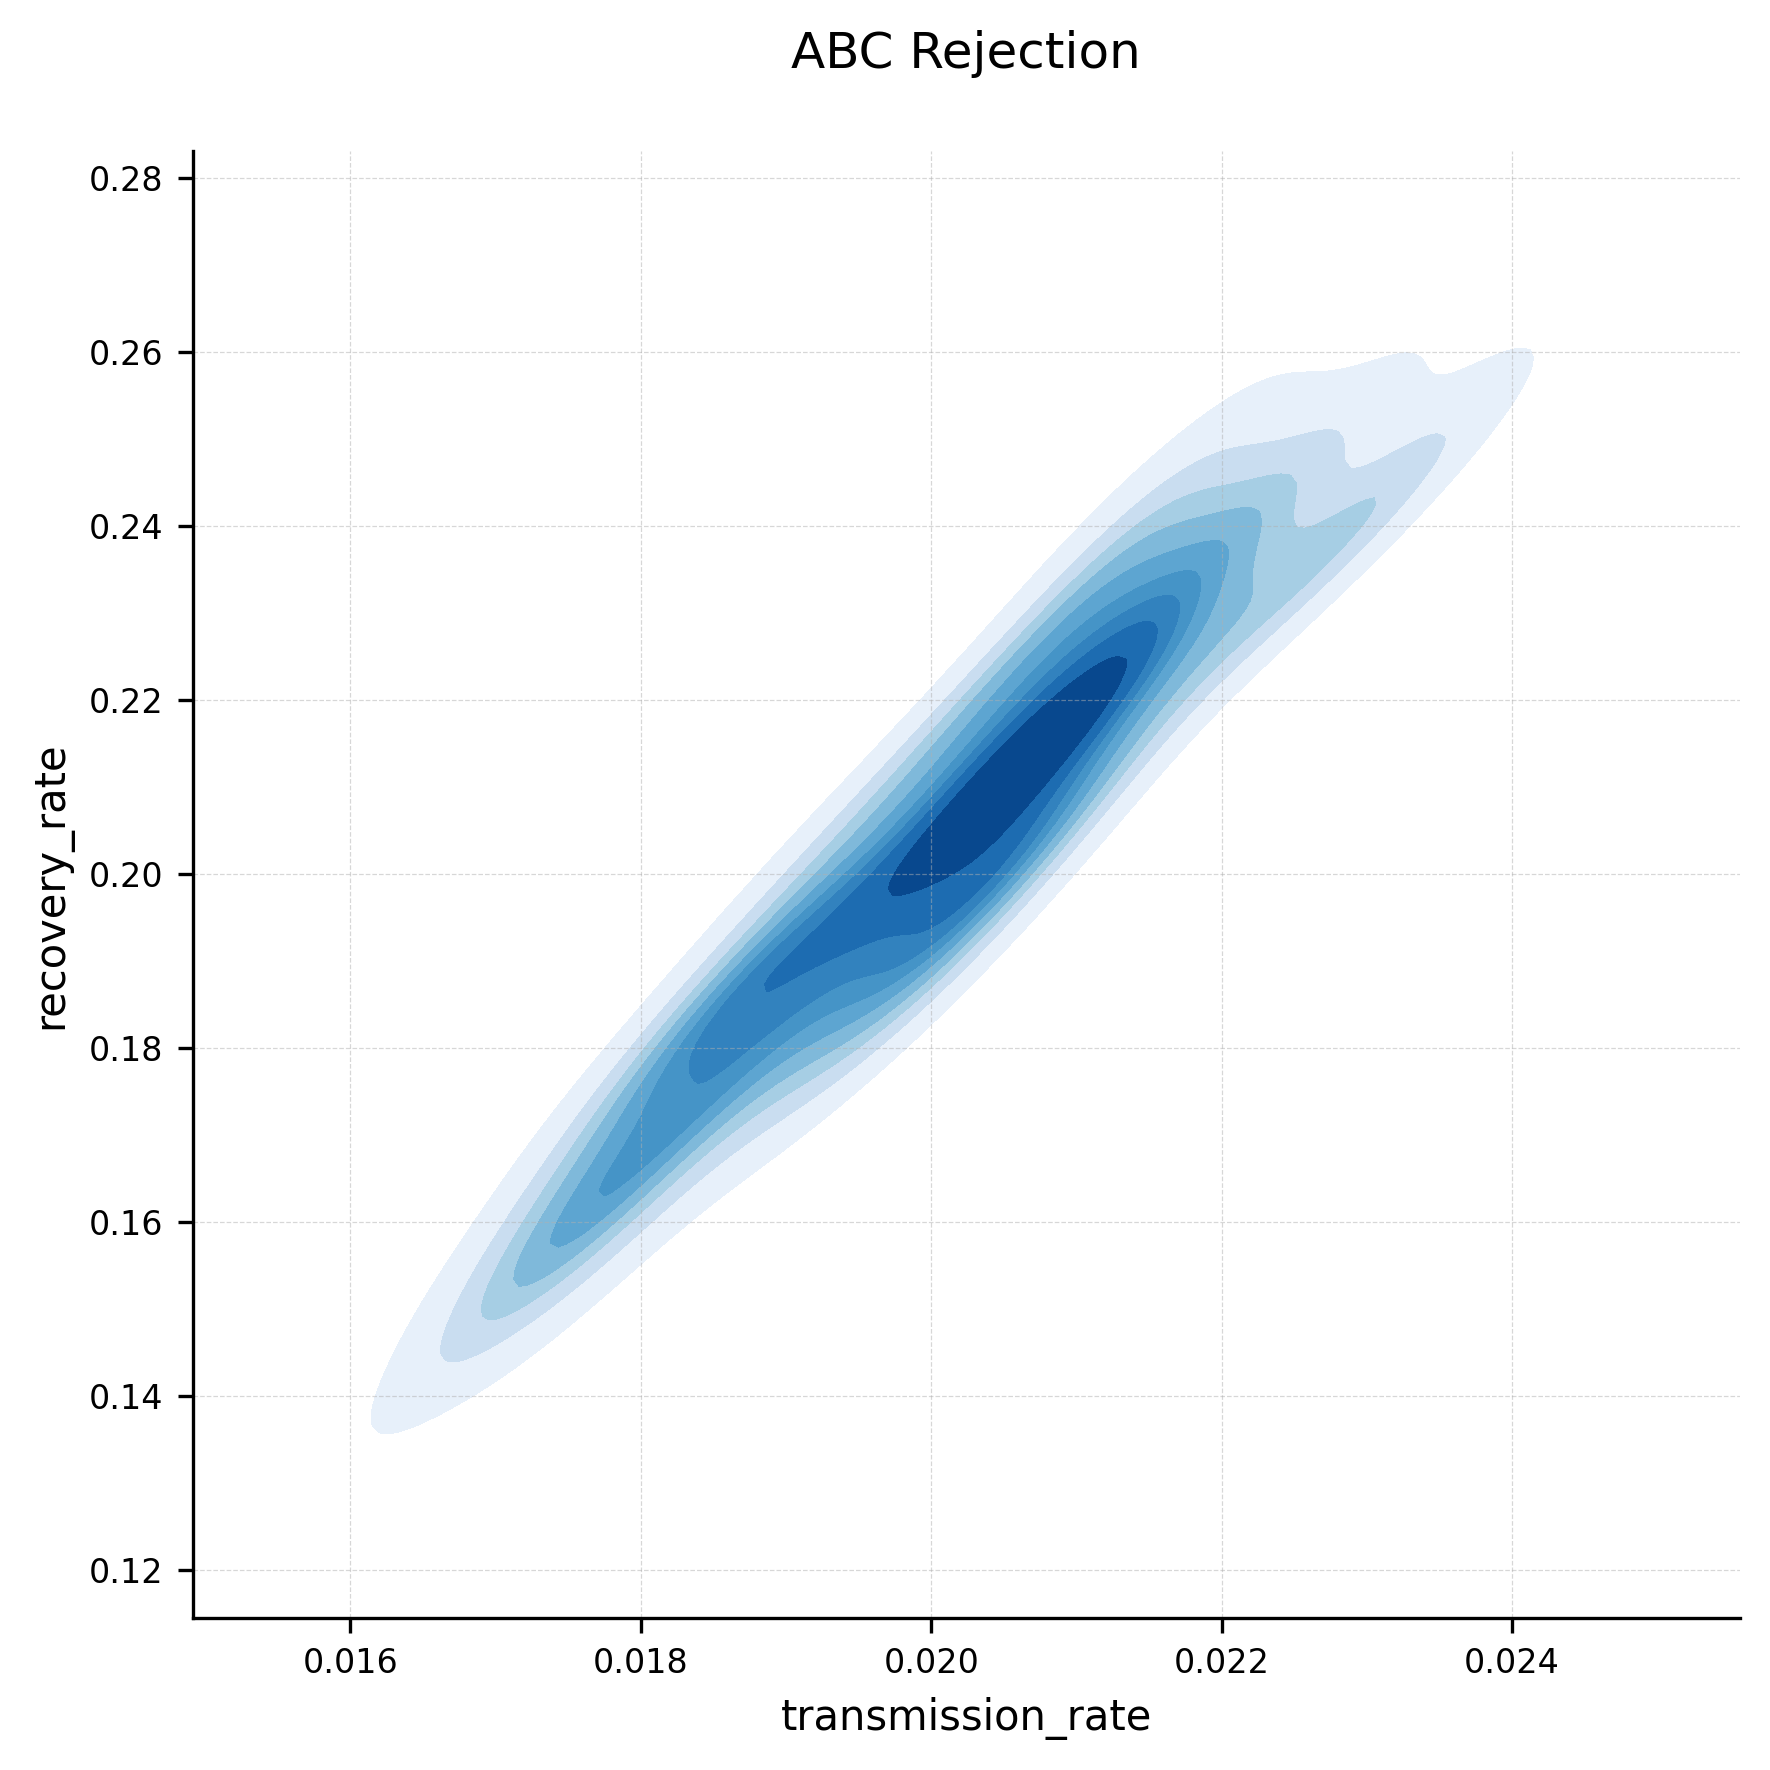

In [17]:
%%R
# ABC Rejection posterior
plot_posterior_distribution_2d(
  results_abc_rejection$get_posterior_distribution(),
  "transmission_rate",
  "recovery_rate",
  kind = "kde",
  title = "ABC Rejection",
  prior_range = FALSE
)

<Axes: title={'center': 'Top 10%'}, xlabel='transmission_rate', ylabel='recovery_rate'>


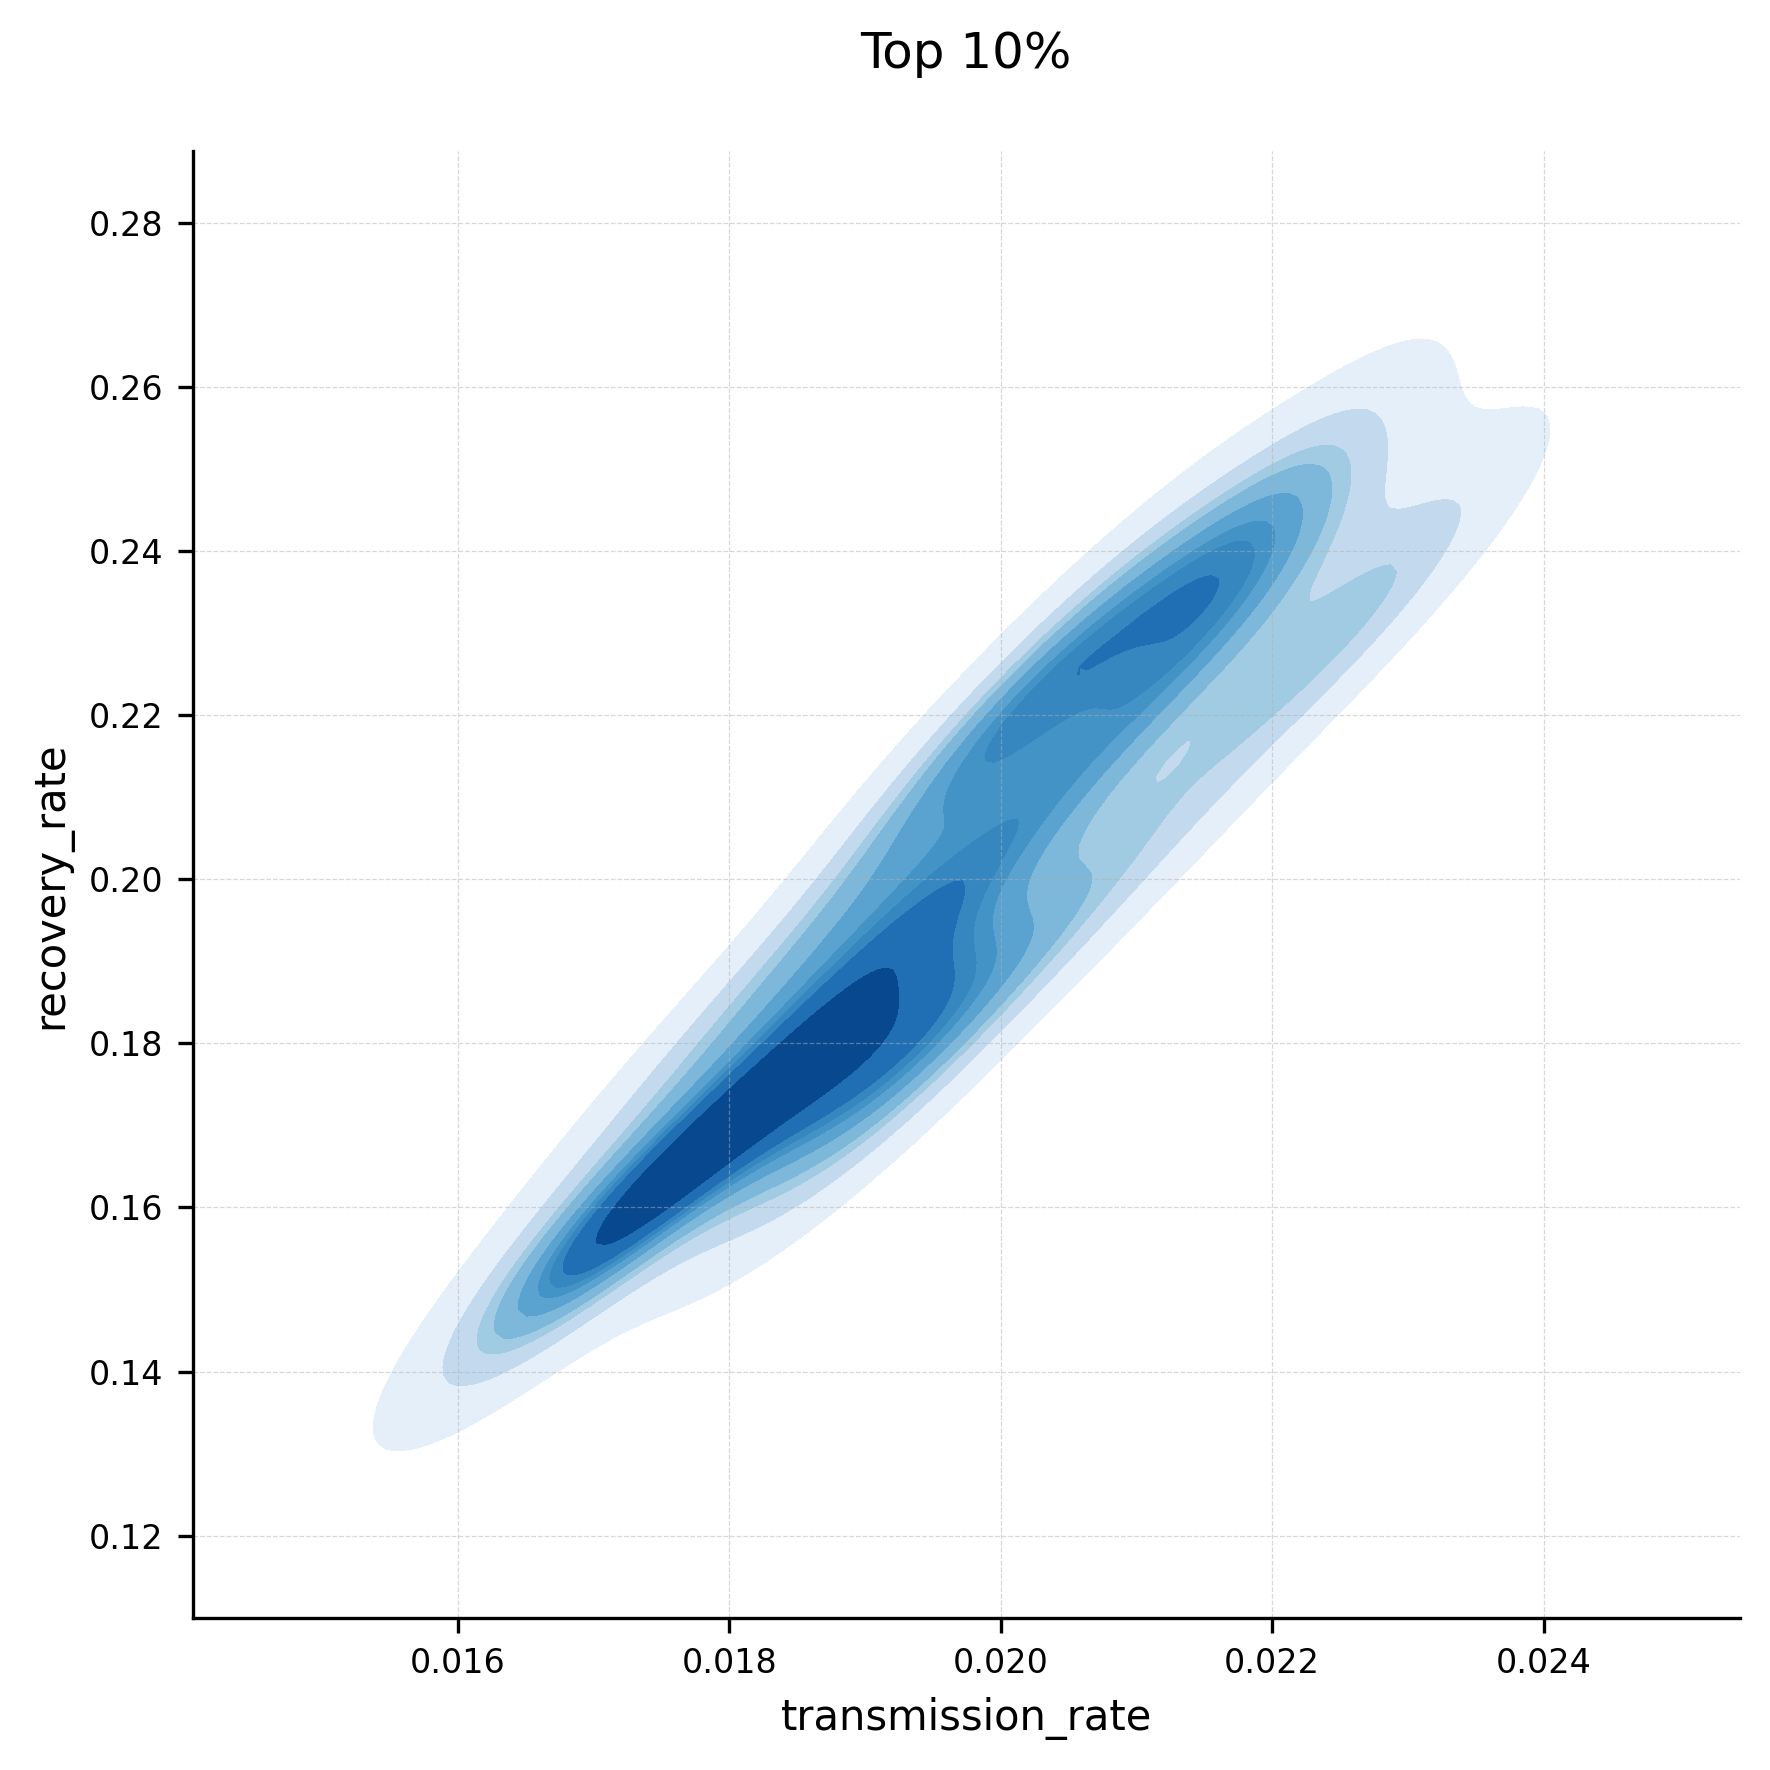

In [18]:
%%R
# Top 10% posterior
plot_posterior_distribution_2d(
  results_top_perc$get_posterior_distribution(),
  "transmission_rate",
  "recovery_rate",
  kind = "kde",
  title = "Top 10%",
  prior_range = FALSE
)

We can also examine the marginal posterior distributions for each parameter:

<Axes: title={'center': 'Transmission Rate Posterior'}, xlabel='transmission_rate', ylabel='Density'>


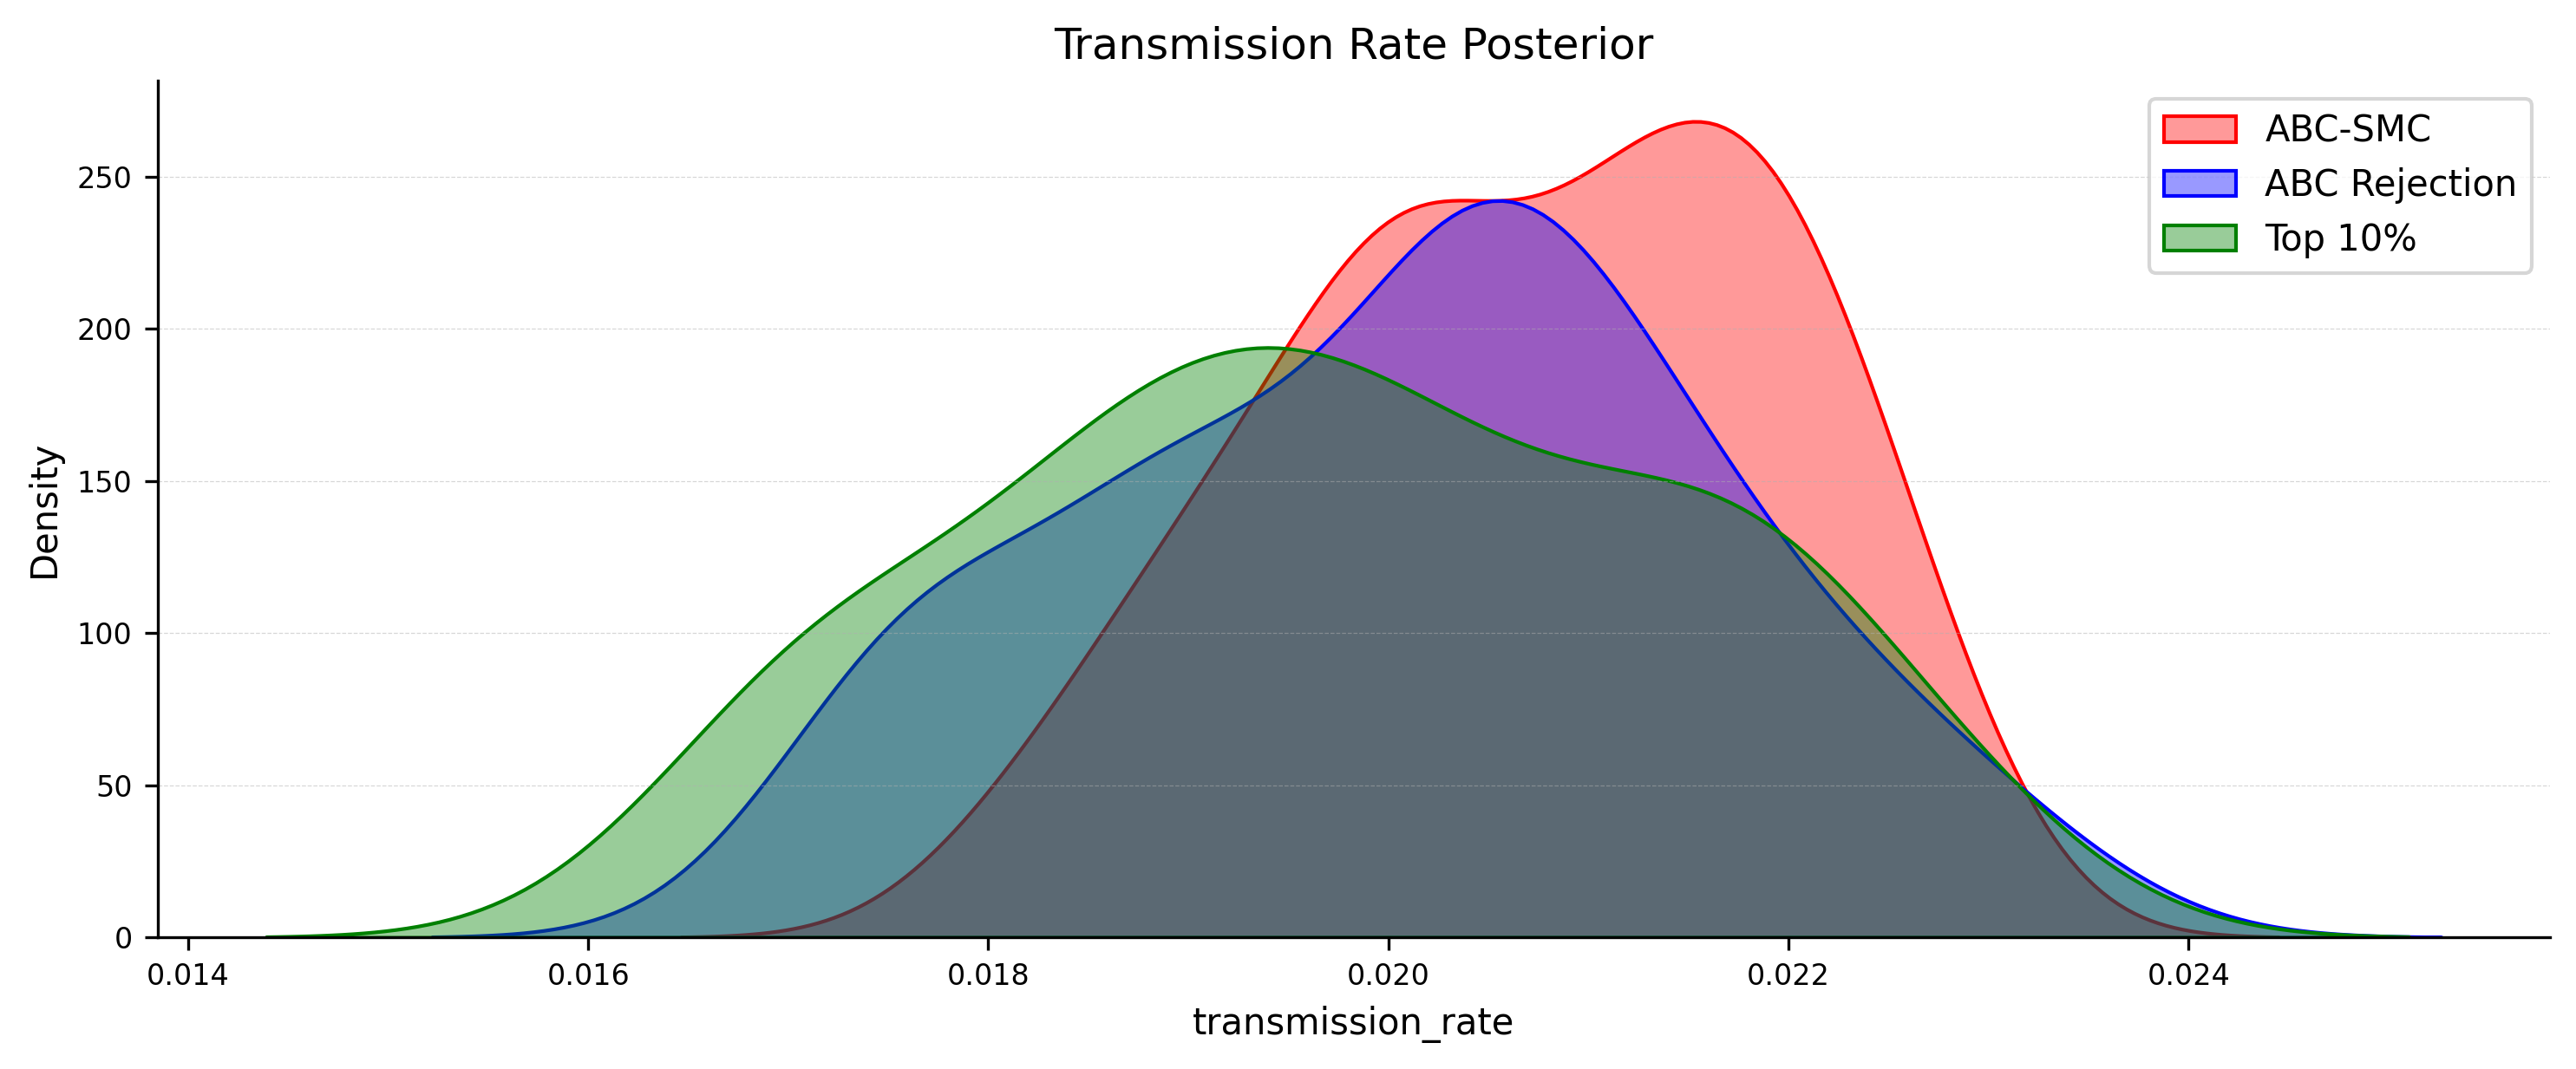

In [19]:
%%R
# Import marginal posterior plotting
plot_posterior_distribution <- viz$plot_posterior_distribution

# Transmission rate - all methods on one plot
ax <- plot_posterior_distribution(
  results_abc_smc$get_posterior_distribution(),
  "transmission_rate",
  kind = "kde",
  color = "red",
  label = "ABC-SMC",
  prior_range = FALSE
)

ax <- plot_posterior_distribution(
  results_abc_rejection$get_posterior_distribution(),
  "transmission_rate",
  kind = "kde",
  color = "blue",
  label = "ABC Rejection",
  prior_range = FALSE,
  ax = ax
)

ax <- plot_posterior_distribution(
  results_top_perc$get_posterior_distribution(),
  "transmission_rate",
  kind = "kde",
  color = "green",
  label = "Top 10%",
  prior_range = FALSE,
  ax = ax
)

ax$set_title("Transmission Rate Posterior")
ax$legend()
ax

<Axes: title={'center': 'Recovery Rate Posterior'}, xlabel='recovery_rate', ylabel='Density'>


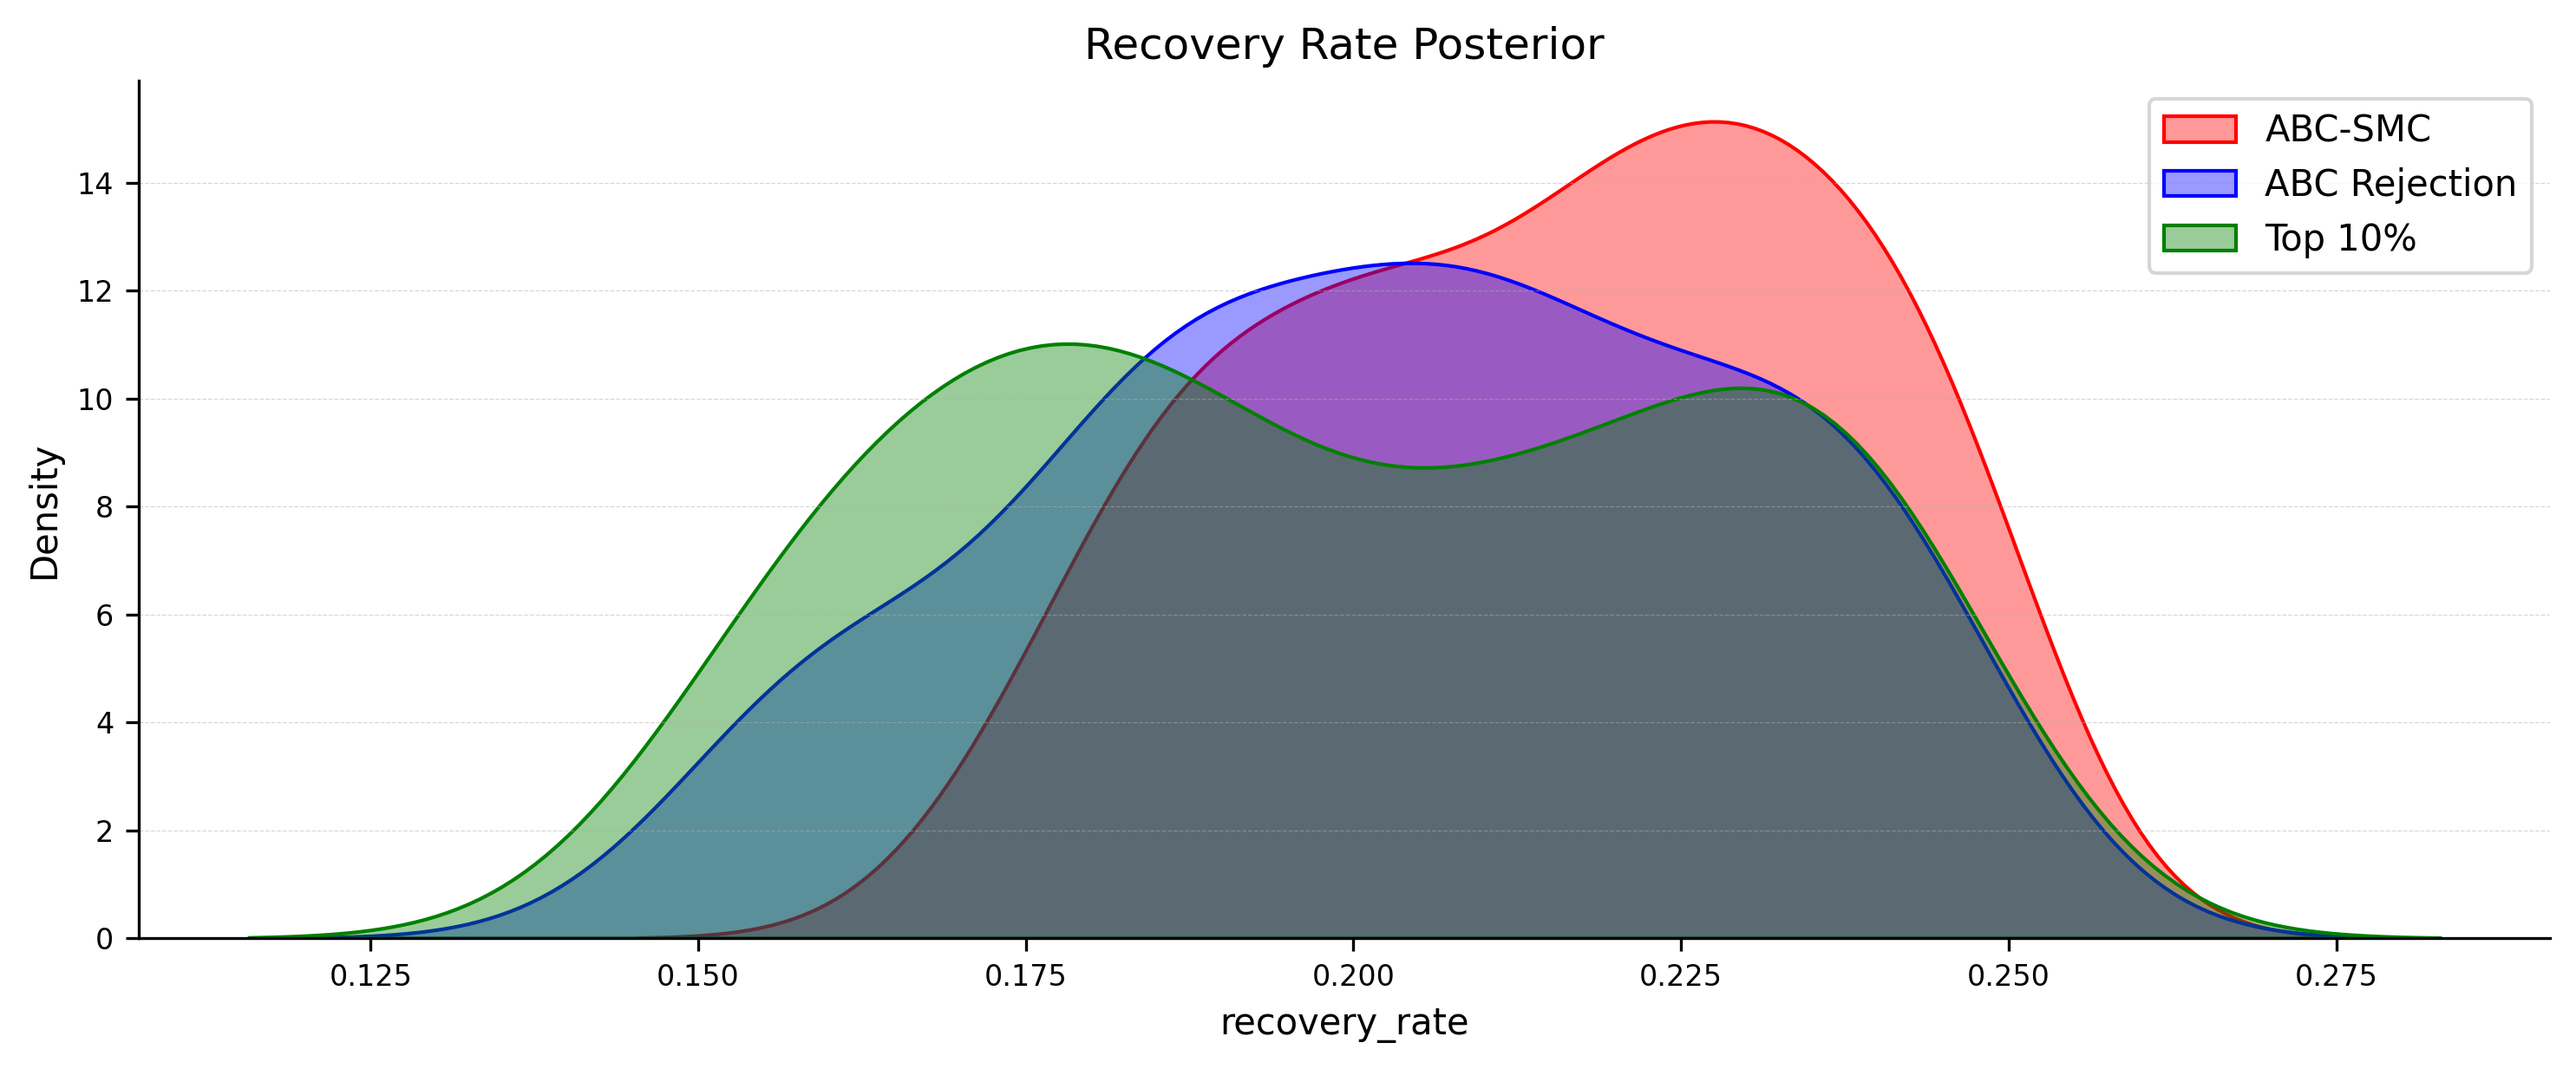

In [20]:
%%R
# Recovery rate - all methods on one plot
ax <- plot_posterior_distribution(
  results_abc_smc$get_posterior_distribution(),
  "recovery_rate",
  kind = "kde",
  color = "red",
  label = "ABC-SMC",
  prior_range = FALSE
)

ax <- plot_posterior_distribution(
  results_abc_rejection$get_posterior_distribution(),
  "recovery_rate",
  kind = "kde",
  color = "blue",
  label = "ABC Rejection",
  prior_range = FALSE,
  ax = ax
)

ax <- plot_posterior_distribution(
  results_top_perc$get_posterior_distribution(),
  "recovery_rate",
  kind = "kde",
  color = "green",
  label = "Top 10%",
  prior_range = FALSE,
  ax = ax
)

ax$set_title("Recovery Rate Posterior")
ax$legend()
ax

### Distance Distributions

The distribution of distances (RMSE) for accepted particles shows how well each method concentrates on good-fitting parameters:

<Axes: title={'center': 'Distribution of Distances for Accepted Particles'}, xlabel='RMSE', ylabel='Density'>


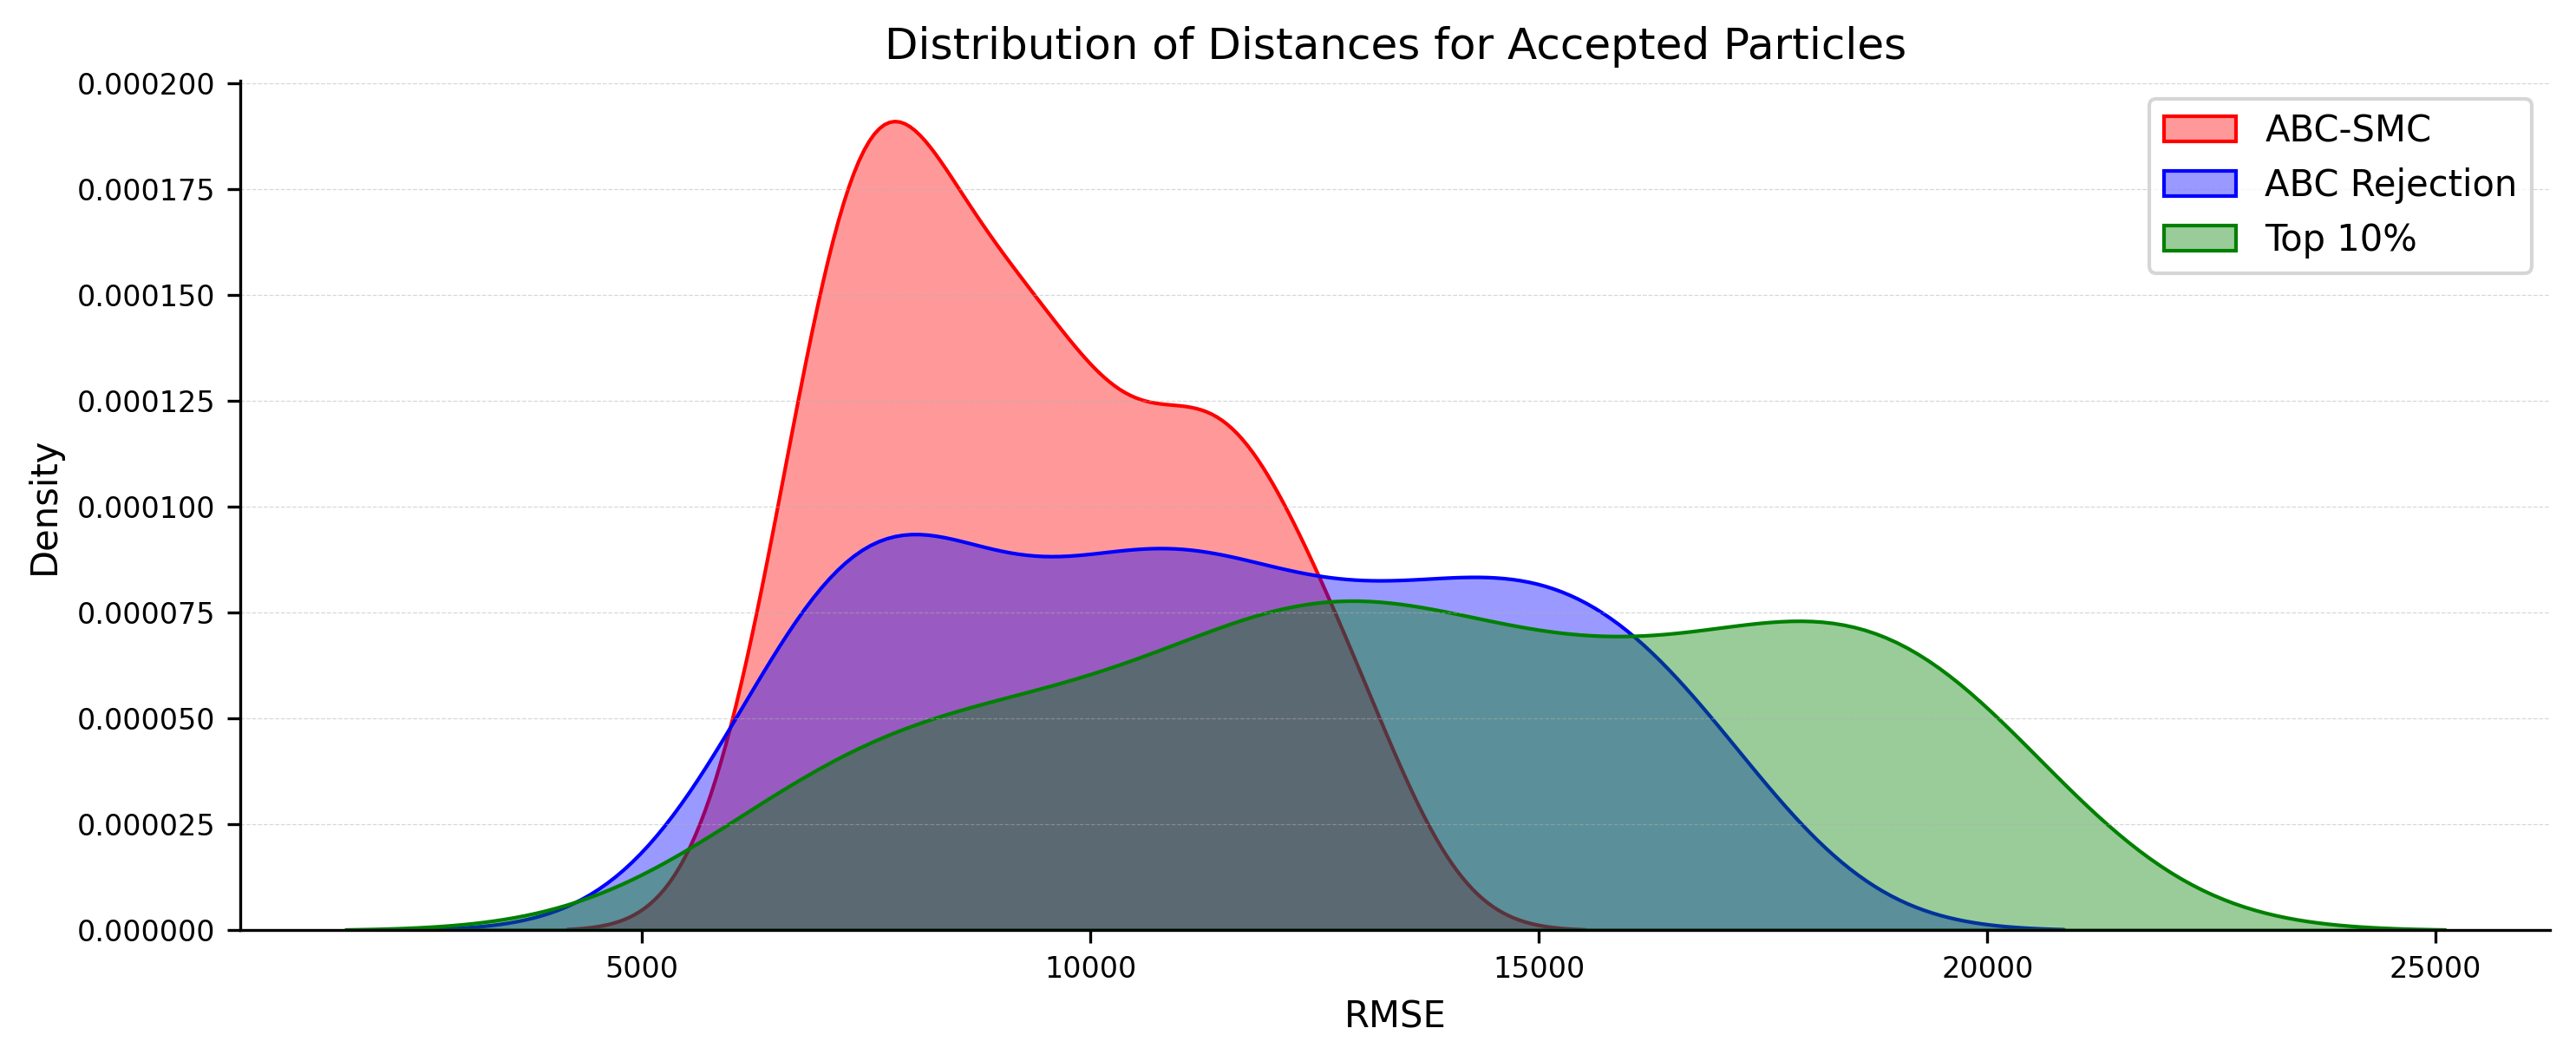

In [21]:
%%R
# Import distance distribution plotting
plot_distance_distribution <- viz$plot_distance_distribution

# Plot all methods on one figure
ax <- plot_distance_distribution(
  results_abc_smc$get_distances(),
  kind = "kde",
  color = "red",
  label = "ABC-SMC",
  xlabel = "RMSE"
)

ax <- plot_distance_distribution(
  results_abc_rejection$get_distances(),
  kind = "kde",
  color = "blue",
  label = "ABC Rejection",
  xlabel = "RMSE",
  ax = ax
)

ax <- plot_distance_distribution(
  results_top_perc$get_distances(),
  kind = "kde",
  color = "green",
  label = "Top 10%",
  xlabel = "RMSE",
  ax = ax
)

ax$set_title("Distribution of Distances for Accepted Particles")
ax$legend()
ax

---
## 6. Running Projections

After calibrating the model, we can project the epidemic forward in time. The `run_projections` method uses the posterior parameter samples to generate future trajectories with uncertainty quantification.

In [22]:
%%R
# Create projection parameters (extend end date)
projection_parameters <- reticulate::dict(
  initial_conditions_dict = initial_conditions,
  epimodel = model,
  start_date = start_date_chr,
  end_date = end_date_projection_chr
)

# Run projections using the calibrated posterior
results_with_projections <- abc_sampler$run_projections(projection_parameters)

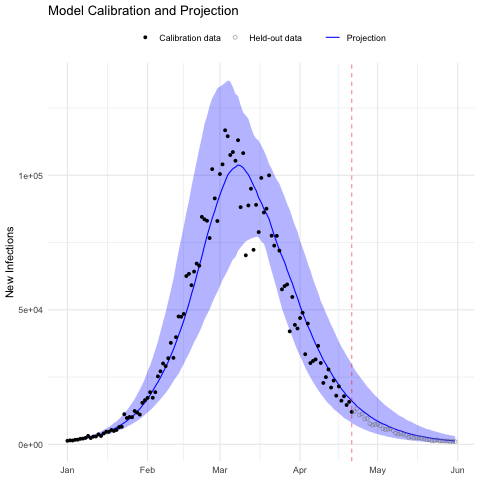

In [23]:
%%R
library(ggplot2)
library(tidyr)

# Extract projection quantiles into an R data frame
df_proj <- py_to_r(results_with_projections$get_projection_quantiles(simulation_dates_projection))
df_proj$date <- as.Date(df_proj$date)

# Pivot to wide format for ribbon plotting
df_proj_wide <- pivot_wider(df_proj, names_from = quantile, values_from = data, names_prefix = "q")

# Plot with ggplot2
ggplot() +
  # Projection ribbon + median
  geom_ribbon(data = df_proj_wide, aes(x = date, ymin = q0.05, ymax = q0.95),
              fill = "blue", alpha = 0.3) +
  geom_line(data = df_proj_wide, aes(x = date, y = q0.5, color = "Projection")) +
  # Observed data points
  geom_point(data = data_calibration, aes(x = date, y = data, shape = "Calibration data"),
             color = "black", size = 1.5) +
  geom_point(data = data_projection, aes(x = date, y = data, shape = "Held-out data"),
             color = "gray50", size = 1.5, alpha = 0.6) +
  # Calibration cutoff
  geom_vline(xintercept = as.numeric(data_calibration$date[nrow(data_calibration)]),
             color = "red", linetype = "dashed", alpha = 0.5) +
  scale_color_manual(values = c("Projection" = "blue")) +
  scale_shape_manual(values = c("Calibration data" = 16, "Held-out data" = 1)) +
  labs(x = NULL, y = "New Infections", title = "Model Calibration and Projection",
       color = NULL, shape = NULL) +
  theme_minimal() +
  theme(legend.position = "top")

---
## Resources

- [Epydemix Documentation](https://epydemix.readthedocs.io/)
- [ABC Methods Reference (Minter et al., 2019)](https://www.sciencedirect.com/science/article/pii/S175543651930026X)
- [ABC-SMC Algorithm (Toni et al., 2009)](https://pubmed.ncbi.nlm.nih.gov/19205079)
- [Reticulate Package](https://rstudio.github.io/reticulate/)